## Trading WTI futures based on the WTI Carry and its momentum

Here we are going to make use of an element that encompasses virtually all aspects of oil trading, i.e., the shape of the futures curve. Typically, this quantity is given a variety of names - depending on whether an economist, an investor, a fundamental or systematic trader is referring to it - but here we will simply use the term carry. The definition of carry is given below

$$ C\left( m_1, m_2\right) = F_{m_1} - F_{m_2},\ \ \ m_1 < m_2$$

denoting the spread between two futures contracts with $ m_1 $ and $ m_2 $ months to expiration. Informally, carry represents the profit and loss (P&L) of a futures trading strategy in the ideal situation when the spot price remains flat and the term structure of futures does not change its shape.

In general, if the oil market is in backwardation, carry is positive and going long oil futures tends to return profits historically. In contrast, when carry becomes negative, i.e., the futures curve moves into contango,
going short oil futures seems to be a profitable strategy. Based on this observation and because going short is as easy as going long in the futures market, we can use a mixed strategy of buying and selling futures contracts depending on the direction of carry.

The validity of the previous observation can be traced back to the fundamentals of supply and demand for the oil market. We quote from [1]:

_The business model of the storage trader is to generate low-risk steady returns by
providing the service of storing oil. In such a business model, the risk of volatile oil
prices must be eliminated by hedging in the futures market. As soon as a physical
barrel is purchased for storage, a financial barrel is sold in the futures market to
reduce the risk. This downward pressure on futures price occurs when the contango
is steep enough to cover the cost of storage. If the market flips to backwardation or
the contango becomes too narrow to economically hold inventories, then the storage
hedger is incentivized to pull oil out of storage and buy back short futures hedges.
This creates an upward pressure on the futures price._

_Carry, or the shape of the futures curve, is the ultimate mechanism that transmits
fundamental information into futures prices. When we read media reports that the
price of oil went up because of stronger Asian demand, or it went down because of
increased OPEC production, these reports do not tell the full story. OPEC itself does
not buy futures and very few oil consumers do. However, any change in supply and
demand impacts the spot-futures spread via variations in convenience yields and
storage costs. The actual futures are bought and sold by storage traders, who react to
the economics determined by the carry. An inventory hedger is indeed the largest trader
in the oil futures market. The systematic carry strategy  essentially trades ahead of
anticipated behavior of the largest market participant, who is acting in response to
the arrival of new fundamental information._

According to [1], the carry strategy generated an annualized log-return of 20.3% over the thirty-year period from 1992 to 2022 with a Sharpe ratio of 0.53. In comparison, the S&P 500 index between February 1992 and May 2024 had a compound annual growth rate of 10.89% and a Sharpe ratio of 0.67.


[1] I. Bouchouev, Virtual Barrels, Springer Texts in Business and Economics (2023).


## Description of the strategy we follow

In this notebook we will implement the previously described carry strategy along with a variation of it called carry momentum. To benchmark our implementation against real world data, we will use the results reported in [2] for the WTI futures contract during the entire 2023 for which we can readily download the data from the IBKR platform.

Our analysis will be based on the 12 month spread $ C \left( 1,13\right) $ to avoid being affected by seasonal variabilities. We will be going long or short WTI contracts depending on the sign of $ C $ while the futures will be rolled on the last business day of each month, following [2]. To achieve this, we will compute synthetic contracts constructed using the cumulative roll differential on the last business day of every month.


[2] I. Bouchouev, Energy Quantamentals: Myths and Realities about Algorithmic Oil Traders, Oxford Institute for Energy Studies (2024).

## Read data for 2023

Here we load the necessary Python libraries and download the WTI price data for 2023 as well as the last business and trading days for every front month future contract.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
#import time
import pandas_market_calendars as mcal

datos = pd.read_csv('data/datos_2023_all.csv')  
last_Day = pd.read_csv('data/last_Day_2023_all.csv')

In [2]:
display(type(datos.loc[0,'date']))
display(type(last_Day.lastBusinessDay.iloc[0]))
display(type(last_Day.lastTradingDay.iloc[0]))

str

str

str

### Convert dates from str to datetime

In [3]:
for ind in datos.index:
    datos.loc[ind,'date'] = dt.datetime.strptime(datos.loc[ind,'date'], '%Y-%m-%d').date()

display(datos.head())

for ind in last_Day.index:
    last_Day.loc[ind,'lastBusinessDay'] = dt.datetime.strptime(last_Day.loc[ind,'lastBusinessDay'], '%Y-%m-%d').date()
    last_Day.loc[ind,'lastTradingDay']  = dt.datetime.strptime(last_Day.loc[ind,'lastTradingDay'], '%Y-%m-%d').date()

display(last_Day.head())

,date,FrontMonth,SecondMonth,ThirteenthMonth,FourteenthMonth
0,2022-11-28,77.24,77.33,74.39,74.02
1,2022-11-29,78.20,78.28,75.22,74.83
2,2022-11-30,80.55,80.66,77.46,77.01
3,2022-12-01,81.22,81.14,77.42,76.98
4,2022-12-02,79.98,80.05,77.46,77.07


,lastBusinessDay,lastTradingDay
0,2022-11-30,2022-12-20
1,2022-12-30,2023-01-20
2,2023-01-31,2023-02-21
3,2023-02-28,2023-03-21
4,2023-03-31,2023-04-20


### Insert a duplicate of the first row in the last_Day dataframe

In [4]:
last_Day.info()

r1 = []
r1.insert(0, {'lastBusinessDay': last_Day.loc[0,'lastBusinessDay'], 'lastTradingDay': last_Day.loc[0,'lastTradingDay']})

last_Day = pd.concat([pd.DataFrame(r1), last_Day], ignore_index=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   lastBusinessDay  14 non-null     object
 1   lastTradingDay   14 non-null     object
dtypes: object(2)
memory usage: 352.0+ bytes


### Compute synthetic front month and thirteenth month contracts upon calculating the cumulative roll differential

In [5]:
datos['FrontSynthetic'] = 0
datos['ThirteenthSynthetic'] = 0
datos['Carry'] = 0
datos['CarrySMA20'] = 0
datos['CarrySMA5'] = 0
datos['CarryMom'] = 0

display(datos.tail())

,date,FrontMonth,SecondMonth,ThirteenthMonth,FourteenthMonth,FrontSynthetic,ThirteenthSynthetic,Carry,CarrySMA20,CarrySMA5,CarryMom
291,2024-01-16,72.40,72.52,69.99,69.67,0,0,0,0,0,0
292,2024-01-17,72.56,72.48,69.75,69.45,0,0,0,0,0,0
293,2024-01-18,74.08,73.95,70.67,70.33,0,0,0,0,0,0
294,2024-01-19,73.41,73.25,69.97,69.65,0,0,0,0,0,0
295,2024-01-22,75.19,74.76,71.44,71.09,0,0,0,0,0,0


In [6]:
# Create synthetic contract

roll_diff_F = 0
roll_diff_T = 0

# index of date used to compute synthetic contracts (could also be today or last date of the series)
indE = 295    # 22-01-2024
print(datos.loc[indE,'date'])

# find index of previous closer lastTradingDay
for indT in range(last_Day.index[-1],-1,-1):
    if datos.loc[indE,'date'] > last_Day.loc[indT,'lastTradingDay']:
        break

# find closer lastBusinessDay
indB = indT + 1

if datos.loc[indE,'date'] == last_Day.loc[indB,'lastBusinessDay']:
    roll_diff_F = roll_diff_F + datos.loc[indE,'SecondMonth']     - datos.loc[indE,'FrontMonth']
    roll_diff_T = roll_diff_T + datos.loc[indE,'FourteenthMonth'] - datos.loc[indE,'ThirteenthMonth']
    datos.loc[indE,'FrontSynthetic'] = datos.loc[indE,'FrontMonth'] + roll_diff_F
    datos.loc[indE,'ThirteenthSynthetic'] = datos.loc[indE,'ThirteenthMonth'] + roll_diff_T
elif datos.loc[indE,'date'] < last_Day.loc[indB,'lastBusinessDay']:
    datos.loc[indE,'FrontSynthetic'] = datos.loc[indE,'FrontMonth'] + roll_diff_F
    datos.loc[indE,'ThirteenthSynthetic'] = datos.loc[indE,'ThirteenthMonth'] + roll_diff_T
else:
    datos.loc[indE,'FrontSynthetic'] = datos.loc[indE,'SecondMonth'] + roll_diff_F
    datos.loc[indE,'ThirteenthSynthetic'] = datos.loc[indE,'FourteenthMonth'] + roll_diff_T

for ind in range(indE-1,-1,-1):
    if datos.loc[ind,'date'] == last_Day.loc[indT,'lastTradingDay']:
        indT = indT - 1
        indB = indB - 1
        datos.loc[ind,'FrontSynthetic'] = datos.loc[ind,'SecondMonth'] + roll_diff_F
        datos.loc[ind,'ThirteenthSynthetic'] = datos.loc[ind,'FourteenthMonth'] + roll_diff_T
    else:
        if datos.loc[ind,'date'] == last_Day.loc[indB,'lastBusinessDay']:
            roll_diff_F = roll_diff_F + datos.loc[ind,'SecondMonth']     - datos.loc[ind,'FrontMonth']
            roll_diff_T = roll_diff_T + datos.loc[ind,'FourteenthMonth'] - datos.loc[ind,'ThirteenthMonth']
            datos.loc[ind,'FrontSynthetic'] = datos.loc[ind,'FrontMonth'] + roll_diff_F
            datos.loc[ind,'ThirteenthSynthetic'] = datos.loc[ind,'ThirteenthMonth'] + roll_diff_T
        elif datos.loc[ind,'date'] < last_Day.loc[indB,'lastBusinessDay']:
            datos.loc[ind,'FrontSynthetic'] = datos.loc[ind,'FrontMonth'] + roll_diff_F
            datos.loc[ind,'ThirteenthSynthetic'] = datos.loc[ind,'ThirteenthMonth'] + roll_diff_T
        else:
            datos.loc[ind,'FrontSynthetic'] = datos.loc[ind,'SecondMonth'] + roll_diff_F
            datos.loc[ind,'ThirteenthSynthetic'] = datos.loc[ind,'FourteenthMonth'] + roll_diff_T
        
display(datos.head())
    


2024-01-22


,date,FrontMonth,SecondMonth,ThirteenthMonth,FourteenthMonth,FrontSynthetic,ThirteenthSynthetic,Carry,CarrySMA20,CarrySMA5,CarryMom
0,2022-11-28,77.24,77.33,74.39,74.02,74.85,69.13,0,0,0,0
1,2022-11-29,78.20,78.28,75.22,74.83,75.81,69.96,0,0,0,0
2,2022-11-30,80.55,80.66,77.46,77.01,78.16,72.20,0,0,0,0
3,2022-12-01,81.22,81.14,77.42,76.98,78.64,72.17,0,0,0,0
4,2022-12-02,79.98,80.05,77.46,77.07,77.55,72.26,0,0,0,0


In [7]:
#datos['Carry'] = datos['FrontSynthetic'] - datos['ThirteenthSynthetic']

datos['Carry'] = datos['FrontMonth'] - datos['ThirteenthMonth']

datos['CarrySMA20'] = datos['Carry'].rolling(20).mean()

datos['CarrySMA5'] = datos['Carry'].rolling(5).mean()

datos['CarryMom'] = datos['Carry'] - datos['CarrySMA20']

display(datos.tail())


,date,FrontMonth,SecondMonth,ThirteenthMonth,FourteenthMonth,FrontSynthetic,ThirteenthSynthetic,Carry,CarrySMA20,CarrySMA5,CarryMom
291,2024-01-16,72.40,72.52,69.99,69.67,72.52,69.67,2.41,2.0825,2.306,0.3275
292,2024-01-17,72.56,72.48,69.75,69.45,72.48,69.45,2.81,2.2040,2.426,0.6060
293,2024-01-18,74.08,73.95,70.67,70.33,73.95,70.33,3.41,2.3505,2.642,1.0595
294,2024-01-19,73.41,73.25,69.97,69.65,73.25,69.65,3.44,2.4340,2.872,1.0060
295,2024-01-22,75.19,74.76,71.44,71.09,74.76,71.09,3.75,2.5195,3.164,1.2305


### Graph of WTI price against the annual Carry

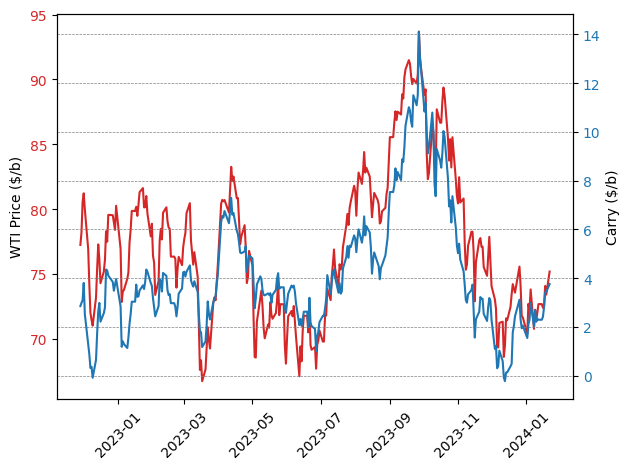

In [8]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('WTI Price ($/b)', rotation=90)
ax1.plot(datos['date'].iloc[:], datos['FrontMonth'].iloc[:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(rotation=45)


ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Carry ($/b)', rotation=90)
ax2.plot(datos['date'].iloc[:], datos['Carry'].iloc[:], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

fig.tight_layout()
plt.show()

In [9]:
print(datos.loc[23,'date'])
print(datos.loc[281,'date'])

2022-12-30
2024-01-02


### Backtesting the Carry strategy

In [10]:
# WTI Carry strategy with rollover on the last business day of each month

import numpy as np

# these two indices determine initial and final dates for the analysis
ind = 23
indE = 281   # End date

pos = 0
open_p = -1
close_p = -1
PnL = [0]
logPnL = [0]
cross_index = []

open_p = datos.iloc[ind].FrontSynthetic
if datos.iloc[ind].Carry > 0:
    pos = 1
else:
    pos = -1
cross_index.append(ind)

# change position when Carry changes sign
for index in datos.iloc[ind+1:indE+1].iterrows():
    indy = index[0]
    
    close_p = datos['FrontSynthetic'].iloc[indy]
    PnL.append(pos*(close_p-open_p))
    logPnL.append(pos*np.log(close_p/open_p))
    open_p = close_p
    
    if datos.iloc[indy].Carry*datos.iloc[indy-1].Carry < 0:
        
        if datos.iloc[indy].Carry > 0:
            pos = 1
        else:
            pos = -1
        cross_index.append(indy)

results = pd.DataFrame(
                {'date': datos['date'].iloc[ind:indE+1],
                 'PnL': PnL,
                 'logPnL': logPnL
                })
results.reset_index(drop=True, inplace=True)
display(results.head())

print('Total PnL in $/b for the given time period:')
print('%.2f' % results.PnL.sum())

logPnL_sum = results.logPnL.sum() * 100

print('Total log-return (%) for the given time period:')
print('%.2f' % logPnL_sum)
        
    

,date,PnL,logPnL
0,2022-12-30,0.00,0.000000
1,2023-01-03,-3.33,-0.043768
2,2023-01-04,-4.02,-0.055524
3,2023-01-05,0.82,0.011579
4,2023-01-06,0.12,0.001683


Total PnL in $/b for the given time period:
-13.26
Total log-return (%) for the given time period:
-18.30


The total log-return here is in close agreement with the results presented in [2] which show a log-return of approximately -20% for 2023. This is one of the few negative yearly performances over the last 30-year period. Furthermore, as one can see in the file _WTI-Carry-Momentum-06-23-06-24.ipynb_, where we obtain a log-return of 14.61% from june 2023 to June 2024, this loss is quickly offset in 2024.

[2] I. Bouchouev, Energy Quantamentals: Myths and Realities about Algorithmic Oil Traders, Oxford Institute for Energy Studies (2024).

### Obtain results for every month in the time interval of interest

In [11]:
results.date = pd.to_datetime(results.date)
PnL_monthly = results.groupby([results['date'].dt.year.rename('year'), results['date'].dt.month_name().rename('month')], sort=False)[['PnL','logPnL']].sum().reset_index()
PnL_monthly['Month'] = pd.to_datetime(PnL_monthly['year'].astype(str)  + PnL_monthly['month'], format='%Y%B')

PnL_monthly.drop([0], inplace=True)
PnL_monthly.reset_index(inplace=True, drop=True)
PnL_monthly['logPnL_c'] = ''
PnL_monthly.loc[0,'logPnL_c'] = PnL_monthly.loc[0,'logPnL'] * 100
for ind in PnL_monthly.index[1:]:
    PnL_monthly.loc[ind,'logPnL_c'] = PnL_monthly.loc[ind-1,'logPnL_c'] + PnL_monthly.loc[ind,'logPnL'] * 100
    
display(PnL_monthly)


,year,month,PnL,logPnL,Month,logPnL_c
0,2023,January,-1.58,-0.020528,2023-01-01,-2.05282
1,2023,February,-2.12,-0.028223,2023-02-01,-4.875158
2,2023,March,-1.52,-0.020737,2023-03-01,-6.948903
3,2023,April,0.98,0.013419,2023-04-01,-5.606968
4,2023,May,-8.52,-0.123170,2023-05-01,-17.923989
5,2023,June,2.40,0.036258,2023-06-01,-14.298214
6,2023,July,11.02,0.151434,2023-07-01,0.845184
7,2023,August,2.31,0.029031,2023-08-01,3.748309
8,2023,September,7.83,0.092570,2023-09-01,13.005313
9,2023,October,-7.78,-0.091951,2023-10-01,3.810225


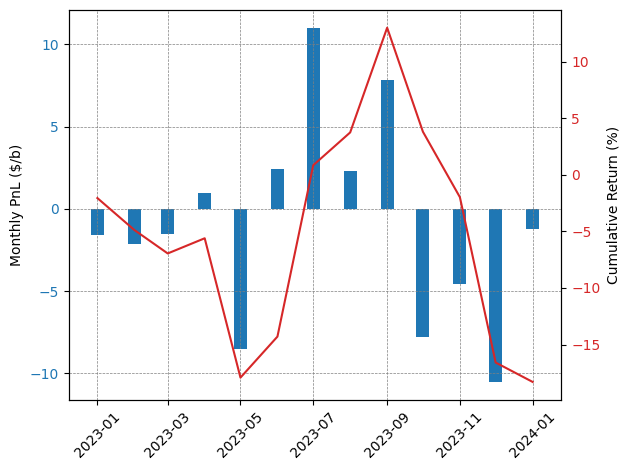

In [12]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('Monthly PnL ($/b)', rotation=90)
ax1.bar(PnL_monthly.Month, PnL_monthly.PnL, width=10.8)
ax1.tick_params(axis='y', labelcolor=color)

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.xticks(rotation=45)


ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Cumulative Return (%)', rotation=90)
ax2.plot(PnL_monthly.Month, PnL_monthly.logPnL_c, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([-20, 20])


fig.tight_layout()
plt.show()

### Total real PnL after commissions in the IBKR platform

In [13]:
## number of MCL contracts traded
n_mcl = 3

# price of 1 MCL contract
pr_mcl = .77

# total PnL (in $) after commissions on IBKR before taxes
print('Total PnL (in $) after commissions on IBKR platform for the given time period:')
# Here we don't take into account the rolling of futures.
total_PnL = results.PnL.sum()*100*n_mcl - pr_mcl*n_mcl*2*len(cross_index) - 1*len(cross_index)
print('%.3f' % total_PnL)

Total PnL (in $) after commissions on IBKR platform for the given time period:
-3994.860


## WTI Carry-Momentum Strategy

The main problem with following the sign of the carry signal is that the oil market does not move regularly between  backwardation and contango and, thus, this strategy does not respond efficiently to swiftly altering market conditions. This is why it makes sense to focus on the change of carry instead of the carry itself. To do this, we can apply the widely used momentum metric to the carry obtaining the so-called carry momentum strategy. According to it, we go long or short the oil futures depending on whether the carry is larger or smaller than the moving average of carry for a given time period. Using the 20-day moving average which corresponds to approximately a one-month lookback period, this strategy generated 24.7% annualized log-returns with Sharpe ratio 0.64 for the 30-year period from 1992 to 2022 (see [1]).


[1] I. Bouchouev, Virtual Barrels, Springer Texts in Business and Economics (2023).

### Graph of WTI price against the 20-day momentum of Carry

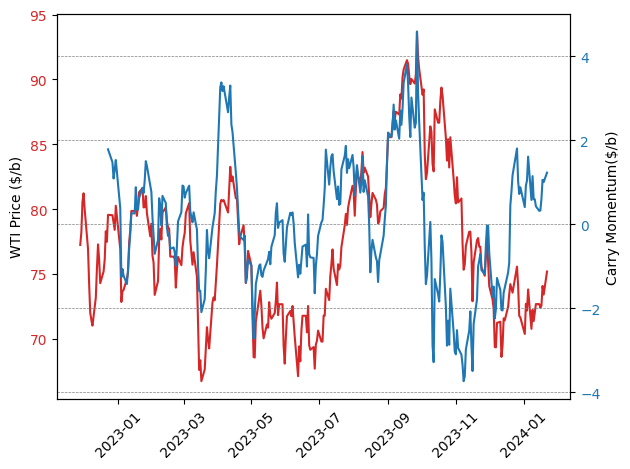

In [14]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('WTI Price ($/b)', rotation=90)
ax1.plot(datos['date'].iloc[:], datos['FrontMonth'].iloc[:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(rotation=45)


ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Carry Momentum($/b)', rotation=90)
ax2.plot(datos['date'].iloc[:], datos['CarryMom'].iloc[:], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

fig.tight_layout()
plt.show()

### Backtesting the Carry-Momentum strategy

In [15]:
# WTI Carry strategy with rollover on the last business day of each month

import numpy as np

# these two indices determine initial and final dates for the analysis
ind = 23
indE = 281   # End date

pos = 0
open_p = -1
close_p = -1
PnL = [0]
logPnL = [0]
cross_index = []

open_p = datos.iloc[ind].FrontSynthetic
if datos.iloc[ind].CarryMom > 0:
    pos = 1
else:
    pos = -1
cross_index.append(ind)

# change position when Carry changes sign
for index in datos.iloc[ind+1:indE+1].iterrows():
    indy = index[0]
    
    close_p = datos['FrontSynthetic'].iloc[indy]
    PnL.append(pos*(close_p-open_p))
    logPnL.append(pos*np.log(close_p/open_p))
    open_p = close_p
    
    if datos.iloc[indy].CarryMom*datos.iloc[indy-1].CarryMom < 0:
        
        if datos.iloc[indy].CarryMom > 0:
            pos = 1
        else:
            pos = -1
        cross_index.append(indy)

results = pd.DataFrame(
                {'date': datos['date'].iloc[ind:indE+1],
                 'PnL': PnL,
                 'logPnL': logPnL
                })
results.reset_index(drop=True, inplace=True)
display(results.head())

print('Total PnL in $/b for the given time period:')
print('%.2f' % results.PnL.sum())

logPnL_sum = results.logPnL.sum() * 100

print('Total log-return (%) for the given time period:')
print('%.2f' % logPnL_sum)
        
    

,date,PnL,logPnL
0,2022-12-30,0.00,0.000000
1,2023-01-03,-3.33,-0.043768
2,2023-01-04,-4.02,-0.055524
3,2023-01-05,-0.82,-0.011579
4,2023-01-06,-0.12,-0.001683


Total PnL in $/b for the given time period:
-9.00
Total log-return (%) for the given time period:
-13.93


The total log-return here is in close agreement with the results presented in [2] which show a log-return of approximately -12% for 2023.

Again, as in the case of the carry strategy, despite the bad returns in 2023, the picture drastically changes in 2024. One can see in the file _WTI-Carry-Momentum-06-23-06-24.ipynb_ that the carry-momentum strategy produced a log-return of 21.93% from june 2023 to June 2024.

[2] I. Bouchouev, Energy Quantamentals: Myths and Realities about Algorithmic Oil Traders, Oxford Institute for Energy Studies (2024).

### Obtain results for every month in the time interval of interest

In [16]:
results.date = pd.to_datetime(results.date)
PnL_monthly = results.groupby([results['date'].dt.year.rename('year'), results['date'].dt.month_name().rename('month')], sort=False)[['PnL','logPnL']].sum().reset_index()
PnL_monthly['Month'] = pd.to_datetime(PnL_monthly['year'].astype(str)  + PnL_monthly['month'], format='%Y%B')

PnL_monthly.drop([0], inplace=True)
PnL_monthly.reset_index(inplace=True, drop=True)
PnL_monthly['logPnL_c'] = ''
PnL_monthly.loc[0,'logPnL_c'] = PnL_monthly.loc[0,'logPnL'] * 100
for ind in PnL_monthly.index[1:]:
    PnL_monthly.loc[ind,'logPnL_c'] = PnL_monthly.loc[ind-1,'logPnL_c'] + PnL_monthly.loc[ind,'logPnL'] * 100
    
display(PnL_monthly)

,year,month,PnL,logPnL,Month,logPnL_c
0,2023,January,-15.60,-0.210348,2023-01-01,-21.034789
1,2023,February,-3.60,-0.047653,2023-02-01,-25.800063
2,2023,March,1.90,0.027485,2023-03-01,-23.051579
3,2023,April,2.16,0.029405,2023-04-01,-20.111045
4,2023,May,-0.06,-0.002472,2023-05-01,-20.358274
5,2023,June,-12.30,-0.182107,2023-06-01,-38.56897
6,2023,July,12.76,0.177418,2023-07-01,-20.827164
7,2023,August,0.99,0.012093,2023-08-01,-19.617876
8,2023,September,7.83,0.092570,2023-09-01,-10.360872
9,2023,October,-5.66,-0.065598,2023-10-01,-16.920709


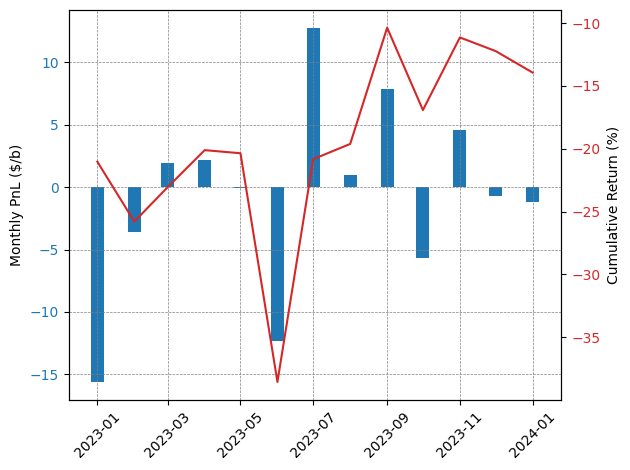

In [17]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('Monthly PnL ($/b)', rotation=90)
ax1.bar(PnL_monthly.Month, PnL_monthly.PnL, width=10.8)
ax1.tick_params(axis='y', labelcolor=color)

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.xticks(rotation=45)


ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Cumulative Return (%)', rotation=90)
ax2.plot(PnL_monthly.Month, PnL_monthly.logPnL_c, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([-20, 20])


fig.tight_layout()
plt.show()

### Total real PnL after commissions in the IBKR platform

In [18]:
## number of MCL contracts traded
n_mcl = 3

# price of 1 MCL contract
pr_mcl = .77

# total PnL (in $) after commissions on IBKR before taxes
print('Total PnL (in $) after commissions on IBKR platform for the given time period:')
# Here we don't take into account the rolling of futures.
total_PnL = results.PnL.sum()*100*n_mcl - pr_mcl*n_mcl*2*len(cross_index) - 1*len(cross_index)
print('%.3f' % total_PnL)

Total PnL (in $) after commissions on IBKR platform for the given time period:
-2851.740
